In [93]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [76]:
df = pd.read_csv('infl_rus.csv')
df = df.iloc[:, 2:]

X = df.drop(columns=["infl_rus"])  # Признаки
y = df["infl_rus"]  # Целевая переменная (инфляция)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df

,infl_rus,MIACR,Infl_exp,M2,Brent,ibk
0,0.39,6.056471,13.037736,31155.6,108.12,6.523469
1,0.49,5.993500,11.795154,29861.2,108.90,6.163086
2,0.82,7.845000,11.522133,30169.0,107.48,6.070468
3,0.87,7.874545,12.672745,29519.3,107.76,5.469189
4,0.85,8.214737,11.720957,29879.0,109.54,6.261563
...,...,...,...,...,...,...
127,0.60,17.760909,12.520500,104351.3,80.36,6.020449
128,0.75,18.460000,13.412700,106242.7,74.02,4.607483
129,0.81,18.925217,13.366700,107629.5,75.63,5.307674
130,1.10,20.645714,13.941200,108947.9,74.35,5.006505


In [77]:
shap.initjs()

In [74]:
model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.11,
    depth=15,
    l2_leaf_reg=5.0,
    grow_policy='Depthwise',
    early_stopping_rounds=3,
    eval_metric='RMSE',  # Метрика для регрессии
    verbose=5
)
model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=3)

0:	learn: 0.4615370	test: 1.6991527	best: 1.6991527 (0)	total: 65.9ms	remaining: 13.1s
5:	learn: 0.4024114	test: 1.6715994	best: 1.6715994 (5)	total: 102ms	remaining: 3.3s
10:	learn: 0.3579946	test: 1.6551419	best: 1.6551419 (10)	total: 139ms	remaining: 2.4s
15:	learn: 0.3215510	test: 1.6416419	best: 1.6416419 (15)	total: 181ms	remaining: 2.08s
20:	learn: 0.2863873	test: 1.6257074	best: 1.6257074 (20)	total: 216ms	remaining: 1.84s
25:	learn: 0.2573875	test: 1.6230140	best: 1.6230140 (25)	total: 261ms	remaining: 1.75s
30:	learn: 0.2322257	test: 1.6154183	best: 1.6154183 (30)	total: 309ms	remaining: 1.69s
35:	learn: 0.2098052	test: 1.6072629	best: 1.6072629 (35)	total: 353ms	remaining: 1.61s
40:	learn: 0.1903213	test: 1.6040089	best: 1.6040089 (40)	total: 403ms	remaining: 1.56s
45:	learn: 0.1724580	test: 1.5983131	best: 1.5983131 (45)	total: 450ms	remaining: 1.5s
50:	learn: 0.1566349	test: 1.5959353	best: 1.5959353 (50)	total: 499ms	remaining: 1.46s
55:	learn: 0.1420252	test: 1.5930750	b

In [87]:
y_pred = model.predict(X_test) 

# Метрики для регрессии
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

MSE: 2.436622035298665
MAE: 0.4167981571546758
R^2: 0.1305076183693321


In [83]:
y_pred

array([0.34203444, 0.44376547, 0.66504973, 0.44236068, 0.4386301 ,
       0.70894115, 0.31028118, 0.8949624 , 0.3887003 , 0.50500872,
       0.15016826, 0.51282446, 0.24144455, 0.72873059, 1.02256016,
       0.23346027, 0.34785934, 0.41116002, 0.16566281, 0.28587999,
       0.55302102, 0.70878732, 0.13241704, 1.53690084, 0.27638759,
       0.31660912, 0.64697227])

<Axes: ylabel='col'>

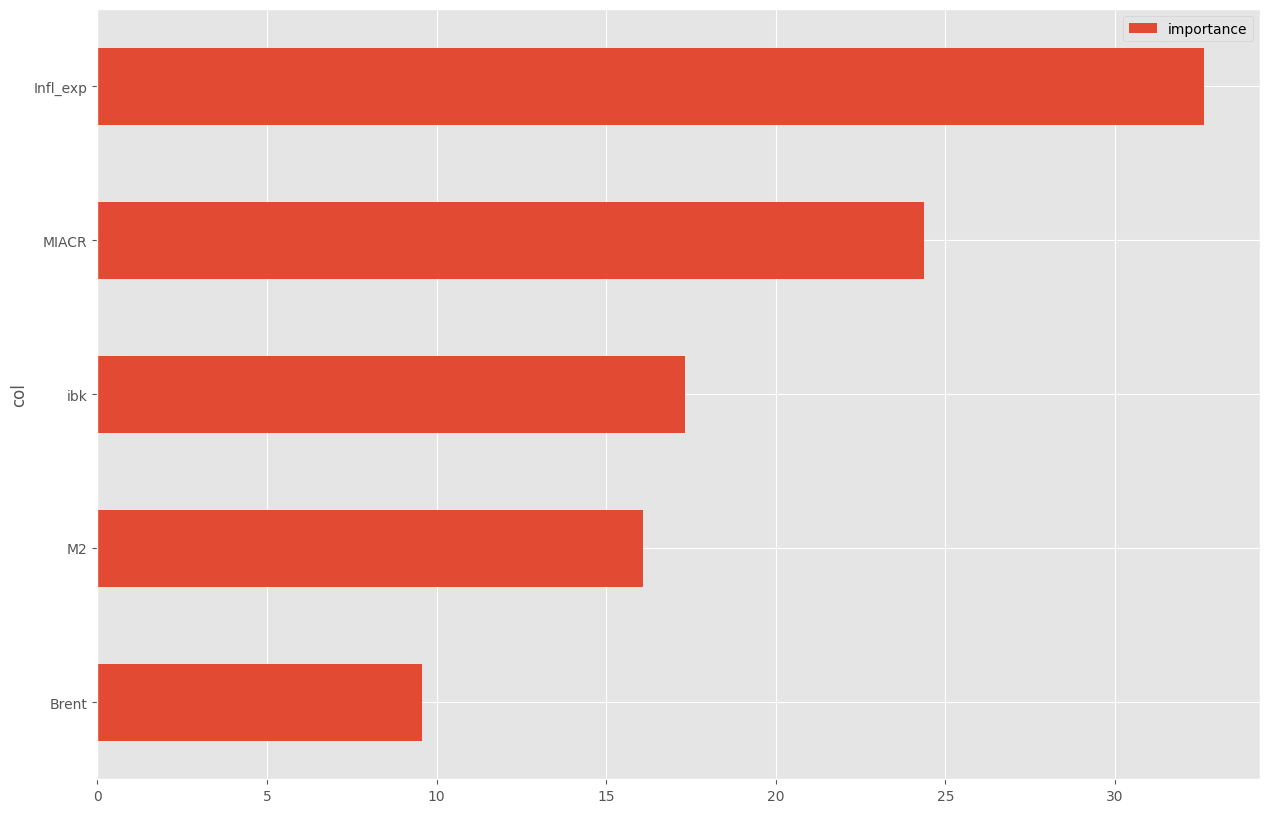

In [94]:

fea_imp = pd.DataFrame({'importance': model.feature_importances_,
                        'col': model.feature_names_})
fea_imp = fea_imp.sort_values(['importance', 'col'], ascending=[True, False])
fea_imp.importance.sum()

fea_imp.tail(25).plot(kind='barh', x='col', y='importance', figsize=(15, 10))

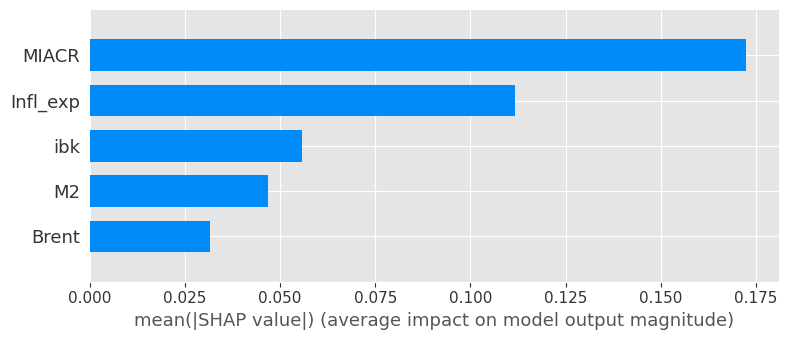

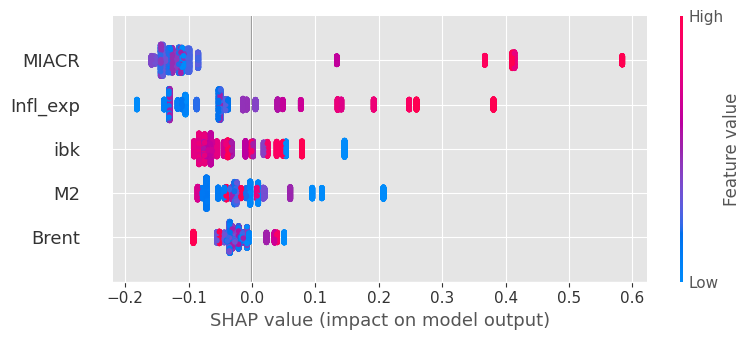

In [123]:
import random
a = random.choices(X_test.index.tolist(), k=5_000)  
yy = y_test.copy()  
yy['pred'] = y_pred  
explainer = shap.TreeExplainer(model)  
shap_values = explainer.shap_values(X_test.loc[a])  
shap.initjs()  
shap.summary_plot(shap_values, X_test.loc[a], plot_type='bar')
shap.summary_plot(shap_values, X_test.loc[a])

In [102]:
yy.loc[a]

83     0.46
31      0.4
56     0.46
36     0.36
47     0.17
       ... 
27      0.5
117    0.89
11     2.55
42     0.13
101    0.18
Name: infl_rus, Length: 5000, dtype: object

In [ ]:
from scipy.special import expit 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

shap_df = pd.DataFrame(data=shap_values.values, columns=x_valid.loc[a].columns.tolist())
shap_df